In [1]:
import quantecon as qe
import numpy as np
P = np.array([[0.4, 0.6], [0.2, 0.8]])
init = (0.25, 0.75)

In [2]:
#-Force Use of no Numba-#

def searchsortedA(a, v):
    """
    Custom version of np.searchsorted. Return the largest index `i` such
    that `a[i-1] <= v < a[i]` (for `i = 0`, `v < a[0]`); if `v[n-1] <=
    v`, return `n`, where `n = len(a)`.

    Parameters
    ----------
    a : ndarray(float, ndim=1)
        Input array. Must be sorted in ascending order.

    v : scalar(float)
        Value to be compared with elements of `a`.

    Returns
    -------
    scalar(int)
        Largest index `i` such that `a[i-1] <= v < a[i]`, or len(a) if
        no such index exists.

    Notes
    -----
    This routine is jit-complied if the module Numba is vailable; if
    not, it is an alias of np.searchsorted(a, v, side='right').

    Examples
    --------
    >>> a = np.array([0.2, 0.4, 1.0])
    >>> searchsorted(a, 0.1)
    0
    >>> searchsorted(a, 0.4)
    2
    >>> searchsorted(a, 2)
    3

    """
    lo = -1
    hi = len(a)
    while(lo < hi-1):
        m = (lo + hi) // 2
        if v < a[m]:
            hi = m
        else:
            lo = m
    return hi

def mc_sample_path_localA(P, init=0, sample_size=1000):
    """
    See Section: DocStrings below
    """
    n = len(P)

    # CDFs, one for each row of P
    cdfs = np.empty((n, n), order='C')  # see issue #137#issuecomment-96128186
    np.cumsum(P, axis=-1, out=cdfs)

    # Random values, uniformly sampled from [0, 1)
    u = np.random.random(size=sample_size)

    # === set up array to store output === #
    X = np.empty(sample_size, dtype=int)
    if isinstance(init, int):
        X[0] = init
    else:
        cdf0 = np.cumsum(init)
        X[0] = searchsortedA(cdf0, u[0])

    # === generate the sample path === #
    for t in range(sample_size-1):
        X[t+1] = searchsortedA(cdfs[X[t]], u[t+1])

    return X

def searchsortedB(a, v):
    return np.searchsorted(a, v, side='right')

def mc_sample_path_localB(P, init=0, sample_size=1000):
    """
    See Section: DocStrings below
    """
    n = len(P)

    # CDFs, one for each row of P
    cdfs = np.empty((n, n), order='C')  # see issue #137#issuecomment-96128186
    np.cumsum(P, axis=-1, out=cdfs)

    # Random values, uniformly sampled from [0, 1)
    u = np.random.random(size=sample_size)

    # === set up array to store output === #
    X = np.empty(sample_size, dtype=int)
    if isinstance(init, int):
        X[0] = init
    else:
        cdf0 = np.cumsum(init)
        X[0] = searchsortedB(cdf0, u[0])

    # === generate the sample path === #
    for t in range(sample_size-1):
        X[t+1] = searchsortedB(cdfs[X[t]], u[t+1])

    return X

In [3]:
results_time = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
results_compile = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
idx = []
for sample_size in [1,10,100,1000,10000,100000,1000000]:
    idx.append(sample_size)
    print "Sample Size: %s" % (sample_size)
    print "qe.numba ..."
    result = %timeit -o qe.mc_sample_path(P, init, sample_size)
    results_time['qe.numba'].append(result.best)
    results_compile['qe.numba'].append(result.compile_time)
    print "qe.numpy ..."
    result = %timeit -o qe.mc_tools.mc_sample_path_numpy(P, init, sample_size)
    results_time['qe.numpy'].append(result.best)
    results_compile['qe.numpy'].append(result.compile_time)    
    print "localA ... "
    result = %timeit -o mc_sample_path_localA(P, init, sample_size)
    results_time['localA'].append(result.best)
    results_compile['localA'].append(result.compile_time)     
    print "localB ... "
    result = %timeit -o mc_sample_path_localB(P, init, sample_size)
    results_time['localB'].append(result.best)
    results_compile['localB'].append(result.compile_time)   

Sample Size: 1
qe.numba ...
The slowest run took 4175.40 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 62.9 µs per loop
qe.numpy ...
10000 loops, best of 3: 20.8 µs per loop
localA ... 
10000 loops, best of 3: 21.4 µs per loop
localB ... 
10000 loops, best of 3: 22.3 µs per loop
Sample Size: 10
qe.numba ...
10000 loops, best of 3: 68.4 µs per loop
qe.numpy ...
10000 loops, best of 3: 40.9 µs per loop
localA ... 
10000 loops, best of 3: 37.7 µs per loop
localB ... 
10000 loops, best of 3: 46.7 µs per loop
Sample Size: 100
qe.numba ...
10000 loops, best of 3: 173 µs per loop
qe.numpy ...
1000 loops, best of 3: 228 µs per loop
localA ... 
10000 loops, best of 3: 183 µs per loop
localB ... 
1000 loops, best of 3: 263 µs per loop
Sample Size: 1000
qe.numba ...
1000 loops, best of 3: 1.19 ms per loop
qe.numpy ...
100 loops, best of 3: 2.1 ms per loop
localA ... 
1000 loops, best of 3: 1.7 ms per loop
localB ... 
100 loops, bes

In [4]:
import pandas as pd
run_time = pd.DataFrame(results_time, index=idx)
run_time.index.name = "Sample Size"

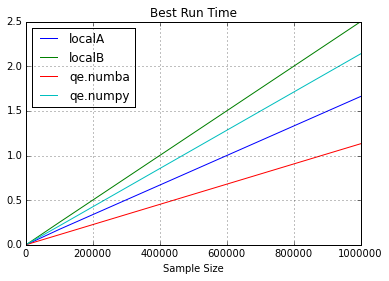

In [5]:
%matplotlib inline
run_time.plot(title="Best Run Time")

In [6]:
compile_time = pd.DataFrame(results_compile, index=idx)
compile_time.index.name = "Sample Size"

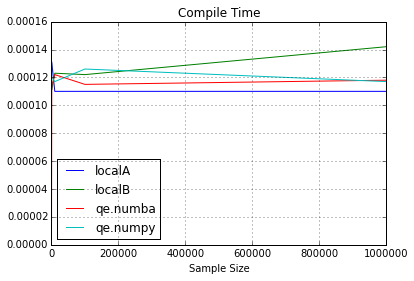

In [7]:
%matplotlib inline
compile_time.plot(title="Compile Time")

In [8]:
#-Focus on Smaller Sample Sizes-#
results_time = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
results_compile = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
idx = []
for sample_size in xrange(1,100,1):
    idx.append(sample_size)
    print "Sample Size: %s" % (sample_size)
    print "qe.numba ..."
    result = %timeit -o qe.mc_sample_path(P, init, sample_size)
    results_time['qe.numba'].append(result.best)
    results_compile['qe.numba'].append(result.compile_time)
    print "qe.numpy ..."
    result = %timeit -o qe.mc_tools.mc_sample_path_numpy(P, init, sample_size)
    results_time['qe.numpy'].append(result.best)
    results_compile['qe.numpy'].append(result.compile_time)    
    print "localA ... "
    result = %timeit -o mc_sample_path_localA(P, init, sample_size)
    results_time['localA'].append(result.best)
    results_compile['localA'].append(result.compile_time)     
    print "localB ... "
    result = %timeit -o mc_sample_path_localB(P, init, sample_size)
    results_time['localB'].append(result.best)
    results_compile['localB'].append(result.compile_time)   

Sample Size: 1
qe.numba ...
The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 56 µs per loop
qe.numpy ...
The slowest run took 4.43 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 20.3 µs per loop
localA ... 
10000 loops, best of 3: 21.4 µs per loop
localB ... 
10000 loops, best of 3: 22 µs per loop
Sample Size: 2
qe.numba ...
10000 loops, best of 3: 58.4 µs per loop
qe.numpy ...
10000 loops, best of 3: 23.3 µs per loop
localA ... 
10000 loops, best of 3: 23.8 µs per loop
localB ... 
10000 loops, best of 3: 25.3 µs per loop
Sample Size: 3
qe.numba ...
10000 loops, best of 3: 60.1 µs per loop
qe.numpy ...
10000 loops, best of 3: 25.6 µs per loop
localA ... 
10000 loops, best of 3: 25.7 µs per loop
localB ... 
10000 loops, best of 3: 27.9 µs per loop
Sample Size: 4
qe.numba ...
10000 loops, best of 3: 61.8 µs per loop
qe.numpy ...

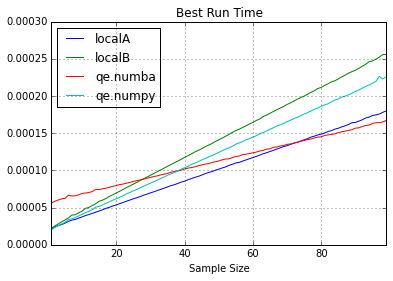

In [9]:
import pandas as pd
run_time = pd.DataFrame(results_time, index=idx)
run_time.index.name = "Sample Size"
%matplotlib inline
run_time.plot(title="Best Run Time")

In [10]:
compile_time = pd.DataFrame(results_compile, index=idx)
compile_time.index.name = "Sample Size"

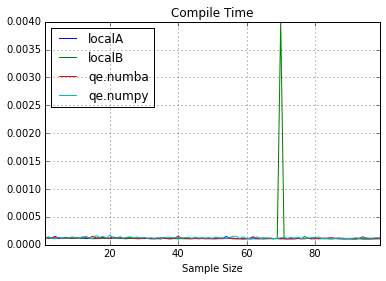

In [11]:
%matplotlib inline
compile_time.plot(title="Compile Time")

In [12]:
#-Look at Matrix Size Performance-#

In [13]:
import numpy as np
from sklearn.preprocessing import normalize

In [14]:
init = 0
sample_size=100000
results_time = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
results_compile = {
    'qe.numba' : [],
    'qe.numpy' : [],
    'localA' : [],
    'localB' : [],
}
idx = []
for n in xrange(2,10000+1,1000):
    #-Generate Matrix P-#
    matrix = np.random.rand(n,n)
    P = normalize(matrix, axis=1, norm='l1')
    idx.append(n)
    print "Matrix Size: %s" % (n)
    print "qe.numba ..."
    result = %timeit -o qe.mc_sample_path(P, init, sample_size)
    results_time['qe.numba'].append(result.best)
    results_compile['qe.numba'].append(result.compile_time)
    print "qe.numpy ..."
    result = %timeit -o qe.mc_tools.mc_sample_path_numpy(P, init, sample_size)
    results_time['qe.numpy'].append(result.best)
    results_compile['qe.numpy'].append(result.compile_time)    
    print "localA ... "
    result = %timeit -o mc_sample_path_localA(P, init, sample_size)
    results_time['localA'].append(result.best)
    results_compile['localA'].append(result.compile_time)     
    print "localB ... "
    result = %timeit -o mc_sample_path_localB(P, init, sample_size)
    results_time['localB'].append(result.best)
    results_compile['localB'].append(result.compile_time)   

Matrix Size: 2
qe.numba ...
1 loops, best of 3: 111 ms per loop
qe.numpy ...
1 loops, best of 3: 209 ms per loop
localA ... 
10 loops, best of 3: 150 ms per loop
localB ... 
1 loops, best of 3: 242 ms per loop
Matrix Size: 1002
qe.numba ...
10 loops, best of 3: 132 ms per loop
qe.numpy ...
1 loops, best of 3: 229 ms per loop
localA ... 
1 loops, best of 3: 450 ms per loop
localB ... 
1 loops, best of 3: 263 ms per loop
Matrix Size: 2002
qe.numba ...
10 loops, best of 3: 149 ms per loop
qe.numpy ...
1 loops, best of 3: 247 ms per loop
localA ... 
1 loops, best of 3: 503 ms per loop
localB ... 
1 loops, best of 3: 280 ms per loop
Matrix Size: 3002
qe.numba ...
10 loops, best of 3: 171 ms per loop
qe.numpy ...
1 loops, best of 3: 271 ms per loop
localA ... 
1 loops, best of 3: 552 ms per loop
localB ... 
1 loops, best of 3: 303 ms per loop
Matrix Size: 4002
qe.numba ...
10 loops, best of 3: 196 ms per loop
qe.numpy ...
1 loops, best of 3: 294 ms per loop
localA ... 
1 loops, best of 3: 58

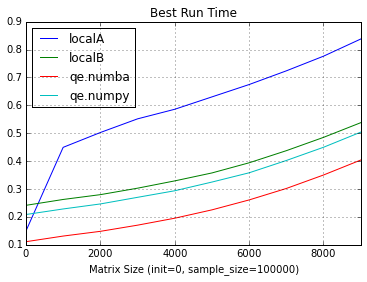

In [15]:
import pandas as pd
run_time = pd.DataFrame(results_time, index=idx)
run_time.index.name = "Matrix Size (init=0, sample_size=%s)"%sample_size
%matplotlib inline
run_time.plot(title="Best Run Time")